# EECE 5642 Data Visualization Midterm Project

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import gensim.models.ldamodel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts

import os
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import fetch_20newsgroups #NEWSGROUPS DATASET


from MulticoreTSNE import MulticoreTSNE as TSNE

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)




### Get All Files From 20_newsgroups Dataset

In [4]:
# define path for where 20_newsgroups is saved (I used slightly cleaned version from download options)
path = '/Users/alexsadler/Desktop/20news-18828/'


# get all files from all folders
all_files = []
for folder in os.listdir(path):
    for file in os.listdir(os.path.join(path, folder)):
        all_files.append((os.path.join(path, folder, file)))

        
# sample of files for testing (so don't have to process ~20,000 files)
files_sample = all_files[0:500]




### Get All Files From 20_newsgroups Dataset Using sklearn

In [5]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='all')

newsgroups_target = newsgroups.target
newsgroups_data = newsgroups.data

len(newsgroups_target)

18846

## Part 1 - Preprocess Data

#### Preprocessing Version 1

In [6]:
stop_words = nltk.corpus.stopwords.words('english')
ws = PorterStemmer()

def tokenize_clean_lem1(file_data):
    """Return cleaned list of words from a given string"""
    # tokenize string from file
    tokens = nltk.tokenize.word_tokenize(file_data)
    # make all words lowercase
    words = [word.lower() for word in tokens]
    # remove tokens that aren't alphabetic
    words = [word for word in words if word.isalpha()]
    # remove stopwords
    words = [word for word in words if word not in stop_words]
    # lemmatize words
    words = [ws.stem(word) for word in words]
    return words


#### Preprocessing Version 2

In [7]:
wl = WordNetLemmatizer()

def get_body_text(file_path):
    """Return body text of file path (skip headers)"""
    with open(file_path) as f:
        body = f.readlines()
        
    for line in range(len(body)):
        if body[line].endswith('writes:\n'):                
            idx_start = line + 1
            break
        # default start at 3 to skip first two header rows
        else:
            idx_start = 3
    
    body = body[idx_start:]         
    body = ' '.join(body)
    
    return body

def tokenize_clean_lem(file_data):
    """Return cleaned list of words from a given string"""
    # tokenize string from file
    tokens = nltk.tokenize.word_tokenize(file_data)
    # make all words lowercase
    words = [word.lower() for word in tokens]
    # remove tokens that aren't alphabetic
    words = [word for word in words if word.isalpha()]
    # remove stopwords
    words = [word for word in words if word not in stop_words]
    # lemmatize words
    words = [wl.lemmatize(word) for word in words]
    # keep only words with three or more letters
    words = [word for word in words if len(word) >= 3]
    
    return words


##### Functions for Word Frequencies and Word/Sentence Extraction

In [51]:
def word_freq(files_list):
    """Return a list of words with number of total mentions for each word from a list of files"""
    all_words = []
    for file in files_list:
        # get tokenized, cleaned, and lemmatized list of words from file
        words = tokenize_clean_lem(file)

        for word in words:
            all_words.append(word)

    # return frequency of words from list of all words from all files    
    fdist_words_all_words = nltk.FreqDist(all_words)
    return fdist_words_all_words.most_common()


word_freqs_list = word_freq(newsgroups_data)

len(word_freqs_list)

70341

In [13]:
def doc_freq(files_list):
    """Return a list of words with number of mentions per document for each word from a list of files"""
    words_by_doc = []
    for file in files_list:
        # get tokenized, cleaned, and lemmatized list of words from file
        words = tokenize_clean_lem(file)
        
        unique_words = list(set(words))
        for word in unique_words:
            words_by_doc.append(word)
    
    # return frequency of words from list of unique words for each file
    fdist_words_by_doc = nltk.FreqDist(words_by_doc)    
    return fdist_words_by_doc.most_common()


doc_freq(newsgroups_data)[:10]

[('would', 5481),
 ('one', 5343),
 ('like', 4197),
 ('know', 3989),
 ('get', 3884),
 ('time', 3296),
 ('also', 3225),
 ('think', 3187),
 ('could', 3023),
 ('people', 2990)]

In [14]:
def sentences(files_list):
    """Return a list of all sentences from files in files_list"""
    all_sentences = []
    for file in files_list:
        # get rid of line breaks and split by sentence
        file_content = file.replace('\n','')    
        sentences = sent_tokenize(file_content)
        
        for sentence in sentences:
            all_sentences.append(sentence)
    
    # return all sentences from all files in files_list
    return all_sentences

sentences(newsgroups_data)[:10]


['I am sure some bashers of Pens fans are pretty confused about the lackof any kind of posts about the recent Pens massacre of the Devils.',
 'Actually,I am  bit puzzled too and a bit relieved.',
 "However, I am going to put an endto non-PIttsburghers' relief with a bit of praise for the Pens.",
 'Man, theyare killing those Devils worse than I thought.',
 'Jagr just showed you whyhe is much better than his regular season stats.',
 'He is also a lotfo fun to watch in the playoffs.',
 'Bowman should let JAgr have a lot offun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway.',
 'I was very disappointed not to see the Islanders lose the finalregular season game.',
 'PENS RULE!!',
 '!']

## Part 2 - Bag of Words and TF-IDF

##### Bag of Words

In [8]:
def bag_of_words(files_list, d_df):
    """Return a term-document count matrix (matrix of # of occurences for each word where each column is a document)"""
    
    # get list of all words and list of word frequency vectors for each document
    all_words = []
    fdist_vectors = []
    for file in files_list:
        # get tokenized, cleaned, and lemmatized list of words from file
        words = tokenize_clean_lem(file)
        # get all words
        for word in words:
            all_words.append(word)
        
        # append frequency distribution of words for each document to fdist_vectors
        fdist_vectors.append(nltk.FreqDist(words))
    
    # get unique words and length of words
    all_words = list(set(all_words))
    len_vocab = len(all_words)
    
    
    # create vectors for each document with word frequency for each document for ALL words
    bag_vectors = []
    for vec in fdist_vectors:
        # initialize each bag of words vector to be zero vector with length of all_words
        bag_vector = np.zeros(len_vocab)
        for idx, word in enumerate(all_words):
            if word in vec:
                bag_vector[idx] = vec[word]
        bag_vectors.append(bag_vector)
    
    #files_names = [file_name[-5:] for file_name in files_sample]
    #df = pd.DataFrame(np.column_stack(bag_vectors), index=all_words, columns=files_names).astype(int)
    df = pd.DataFrame(np.column_stack(bag_vectors), index=all_words).astype(int)
    if(d_df):
        return bag_vectors, all_words, files_names
    else:
        return df

bow_matrix = bag_of_words(newsgroups_data, 0)
bow_matrix.head()


0      1      2      3      4      5      6      7      8      \
vying          0      0      0      0      0      0      0      0      0   
rebelled       0      0      0      0      0      0      0      0      0   
miniscule      0      0      0      0      0      0      0      0      0   
lkerdi         0      0      0      0      0      0      0      0      0   
tavares        0      0      0      0      0      0      0      0      0   

           9      ...    18836  18837  18838  18839  18840  18841  18842  \
vying          0  ...        0      0      0      0      0      0      0   
rebelled       0  ...        0      0      0      0      0      0      0   
miniscule      0  ...        0      0      0      0      0      0      0   
lkerdi         0  ...        0      0      0      0      0      0      0   
tavares        0  ...        0      0      0      0      0      0      0   

           18843  18844  18845  
vying          0      0      0  
rebelled       0      0      0  
miniscule      0      0      0  
lkerdi         0      0      0  
tavares        0      0      0  

[5 rows x 18846 columns]

In [1]:
# filter bow matrix to include words that appear 5 or more times in the corpus
#bow_matrix = bow_matrix[bow_matrix >= 5].dropna(axis=0,how='all')
#bow_matrix.fillna(0,inplace=True)

##### TF-IDF
Calculating TF-IDF matrix with formula: weight = term_freq * log10(total number of docs / number of docs with term in it)

In [9]:
# convert bag of words matrix to binary term-document incidence matrix
tfidf_matrix = bow_matrix
tfidf_matrix[tfidf_matrix != 0] = 1

# get inverse document frequency
idf = np.log10(len(tfidf_matrix.columns)/tfidf_matrix.sum(axis=1))

# multiply bag of words matrix by frequency
tfidf_matrix = bow_matrix.multiply(idf,axis=0).round(2)

# use below if dictionary of dictionaries wanted with keys as file names ({column -> {index -> value}})
#tfidf.to_dict()
# use below if bag of words matrix wanted
tfidf_matrix.head()


0      1      2      3      4      5      6      7      8      \
vying        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
rebelled     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
miniscule    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
lkerdi       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
tavares      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

           9      ...    18836  18837  18838  18839  18840  18841  18842  \
vying        0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
rebelled     0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
miniscule    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
lkerdi       0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
tavares      0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   

           18843  18844  18845  
vying        0.0    0.0    0.0  
rebelled     0.0    0.0    0.0  
miniscule    0.0    0.0    0.0  
lkerdi       0.0    0.0    0.0  
tavares      0.0    0.0    0.0  

[5 rows x 18846 columns]

In [ ]:
# convert bag of words matrix to binary term-document incidence matrix
bow_mat, all_words, files_names = bag_of_words(newsgroups_data,1)
tf_mat, all_words, files_names = bag_of_words(newsgroups_data,1)
tf_mat[tf_mat != 0] = 1

print(len(bow_mat), len(all_words), len(files_names))
# get inverse document frequency
sum_of = 0
for i in range(len(tf_mat)):
    sum_of = sum_of + tf_mat[i]

idf_mat = np.log10(len(tf_mat)/sum_of)

# multiply bag of words matrix by frequency
for j in range(len(tf_mat)):
    tf_mat[j] = bow_mat[j]*idf_mat[j] 
    
    tf_mat[j].round(2)

tf_dict = {'Document': files_names, 'Word': all_words, 'Uses': tf_matrix}

### Data Visualizations

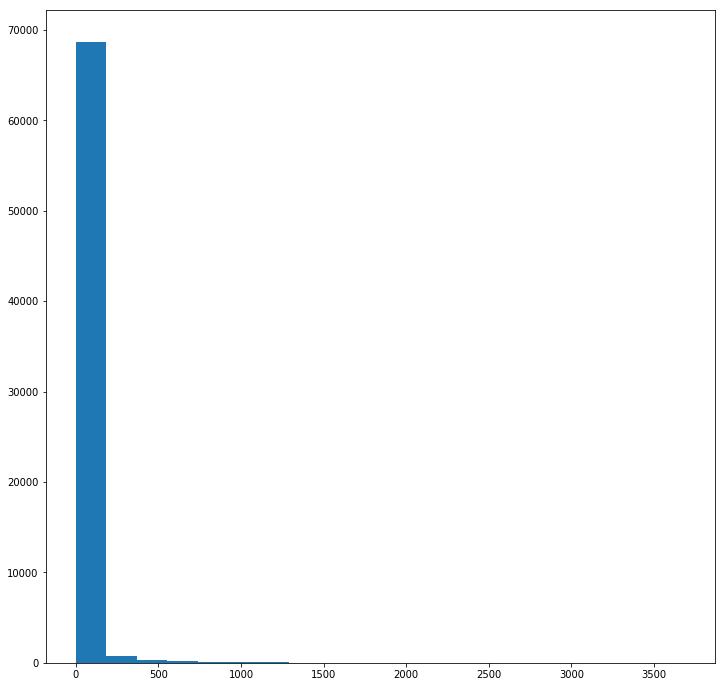

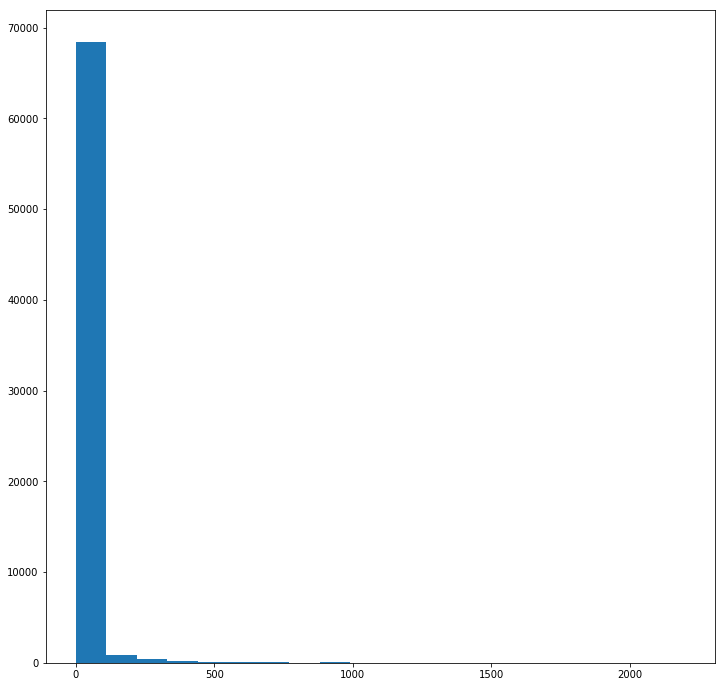

In [15]:
words = []
freq_list1 = [idx[1] for idx in word_freq(newsgroups_data)[25:]]
doc_list1 = [idx[1] for idx in doc_freq(newsgroups_data)[25:]]     
    
plt.figure(figsize=(12,12))
plt.hist(freq_list1,bins=20)
plt.show()

plt.figure(figsize=(12,12))
plt.hist(doc_list1,bins=20)
plt.show()


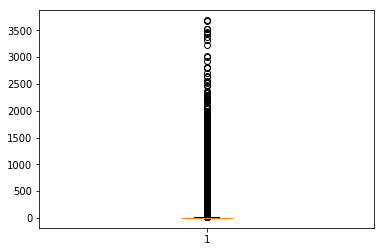

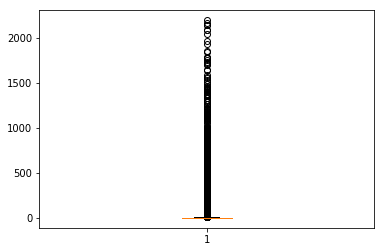

In [16]:
plt.figure()
plt.boxplot(freq_list1)
plt.show()

plt.figure()
plt.boxplot(doc_list1)
plt.show()

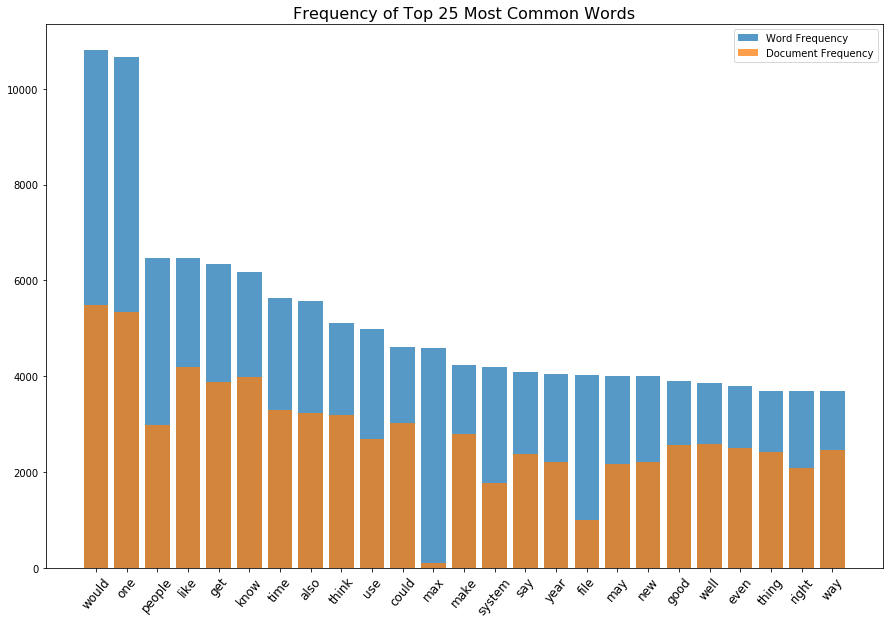

In [17]:
# get top n_top_words most frequent words from corpus
n_top_words = 25
word_freq_list = word_freq(newsgroups_data)[:n_top_words]
terms_words, word_freqs = zip(*word_freq_list)

# get document frequency for all words
doc_freq_list = doc_freq(newsgroups_data)
terms_docs, doc_freqs = zip(*doc_freq_list)

# find corresponding document frequency for each of most frequent words from corpus
doc_freqs_list = []
for word in terms_words:
    idx = terms_docs.index(word)
    doc_freqs_list.append(doc_freqs[idx])

plt.figure(figsize=(15,10))
plt.title('Frequency of Top {} Most Common Words'.format(n_top_words),size=16)
plt.bar(range(n_top_words), word_freqs, align='center', tick_label=terms_words, alpha=0.75, label='Word Frequency')
plt.bar(range(n_top_words), doc_freqs_list, align='center', tick_label=terms_words, alpha=0.75, label='Document Frequency')
plt.xticks(rotation=50,size=12)
plt.legend()
plt.show()



## Part 3 - LDA Models

##### Generate id2word and corpus for selected preprocess method

In [18]:
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

def generate(files_list, method):
    all_words = []
    for file in files_list:
        # get tokenized, cleaned, and lemmatized list of words from file
        if method == 1:
            words = tokenize_clean_lem1(file)
        elif method == 2:
            words = tokenize_clean_lem(file)
        else:
            raise ValueError("Input Valid Number")
        
        all_words.append(words)
        
    return all_words



##### Preprocess method 1

In [19]:
data_method_1 = generate(newsgroups_data, 1)

# create dictionary of words for each document    
id2word_1 = corpora.Dictionary(data_method_1)
id2word_1.filter_extremes(no_below=15, no_above=0.75, keep_n=100000)

# get term document frequency
corpus_1 = [id2word_1.doc2bow(text) for text in data_method_1]

# LDA model
lda_model_bow_1 = gensim.models.ldamodel.LdaModel(corpus=corpus_1,
                                            id2word=id2word_1,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_bow_1, corpus_1, id2word_1)
vis


/Users/alexsadler/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.263884 -0.022808       1        1  21.966293
13     0.295687 -0.050505       2        1  18.403511
10     0.220723 -0.074040       3        1  13.802088
7      0.195546  0.182608       4        1   8.317576
19     0.116188 -0.148026       5        1   7.748543
12     0.067385 -0.031337       6        1   7.056745
8      0.009928  0.363381       7        1   2.846902
0     -0.088742  0.018810       8        1   2.288575
4     -0.078826  0.056526       9        1   2.162688
17    -0.117906 -0.023276      10        1   1.845791
14    -0.067276 -0.110054      11        1   1.841232
1     -0.094991 -0.090799      12        1   1.746701
15     0.066243 -0.043650      13        1   1.479235
9     -0.069275  0.001119      14        1   1.468844
18    -0.123098 -0.073747      15        1   1.407302
6     -0.097036  0.148301      16        1   1.406207
3     -0.126652 -0.033259      17        1   1.381158
5     -0.117250 -0.010739      18        1   1.155568
2     -0.129139 -0.030606      19        1   0.837824
16    -0.125392 -0.027897      20        1   0.837215, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
173   Default  16115.000000         use  16115.000000  30.0000  30.0000
1894  Default   6790.000000         god   6790.000000  29.0000  29.0000
195   Default   6073.000000      system   6073.000000  28.0000  28.0000
578   Default   5336.000000           x   5336.000000  27.0000  27.0000
1468  Default   4497.000000           q   4497.000000  26.0000  26.0000
192   Default   4911.000000     program   4911.000000  25.0000  25.0000
1097  Default   4189.000000           c   4189.000000  24.0000  24.0000
619   Default   3547.000000           b   3547.000000  23.0000  23.0000
586   Default   3726.000000        imag   3726.000000  22.0000  22.0000
575   Default  14295.000000       would  14295.000000  21.0000  21.0000
124   Default   6378.000000         say   6378.000000  20.0000  20.0000
106   Default  10027.000000        like  10027.000000  19.0000  19.0000
103   Default   8645.000000        know   8645.000000  18.0000  18.0000
108   Default   5813.000000         new   5813.000000  17.0000  17.0000
472   Default   9359.000000       peopl   9359.000000  16.0000  16.0000
1242  Default   3090.000000         key   3090.000000  15.0000  15.0000
112   Default  13663.000000         one  13663.000000  14.0000  14.0000
759   Default   2502.000000       power   2502.000000  13.0000  13.0000
224   Default  10120.000000         get  10120.000000  12.0000  12.0000
152   Default   2856.000000        data   2856.000000  11.0000  11.0000
559   Default   3911.000000          us   3911.000000  10.0000  10.0000
610   Default   2554.000000      report   2554.000000   9.0000   9.0000
267   Default   3707.000000      believ   3707.000000   8.0000   8.0000
1     Default   8098.000000        also   8098.000000   7.0000   7.0000
181   Default   2776.000000       drive   2776.000000   6.0000   6.0000
556   Default   2989.000000     univers   2989.000000   5.0000   5.0000
1151  Default   4003.000000        file   4003.000000   4.0000   4.0000
1081  Default   4005.000000         run   4005.000000   3.0000   3.0000
56    Default   2521.000000        card   2521.000000   2.0000   2.0000
283   Default   2382.000000   christian   2382.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
23    Topic20    549.779480        lack    551.231873   4.7802  -3.1516
1499  Topic20    533.998352         hot    535.450745   4.7801  -3.1807
1802  Topic20    529.335205         air    530.787598   4.7801  -3.1895
25    Topic20    442.901611        lose    444.353973   4.7796  -3.3678
47    Topic20    438.331757        stat    439.784119   4.7795  -3.3782
14    Topic20    420.275330      

##### Preprocess method 2

In [20]:
data_method_2 = generate(newsgroups_data, 2)

# create dictionary of words for each document    
id2word_2 = corpora.Dictionary(data_method_2)
id2word_2.filter_extremes(no_below=5, no_above=0.75, keep_n=100000)

# get term document frequency
corpus_2 = [id2word_2.doc2bow(text) for text in data_method_2]
# LDA model
lda_model_bow_2 = gensim.models.ldamodel.LdaModel(corpus=corpus_2,
                                            id2word=id2word_2,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_bow_2, corpus_2, id2word_2)
vis

/Users/alexsadler/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.275522 -0.023381       1        1  23.080196
9      0.285250  0.062144       2        1  19.252405
3      0.194671  0.213049       3        1   9.866723
16     0.159313 -0.156403       4        1   7.898524
10     0.104113 -0.081927       5        1   5.513762
14     0.036753 -0.251977       6        1   4.446888
13    -0.061358  0.017909       7        1   3.977714
11    -0.016145 -0.059644       8        1   3.548197
0     -0.018295 -0.196650       9        1   3.344858
8     -0.028878 -0.092544      10        1   3.080708
15    -0.076930  0.049792      11        1   2.706022
7      0.101981  0.198786      12        1   2.474194
19    -0.102802  0.028185      13        1   2.314258
12    -0.129386 -0.000884      14        1   1.825986
17    -0.125564  0.012172      15        1   1.576683
6     -0.093441 -0.020168      16        1   1.256853
18    -0.066869  0.180734      17        1   1.179703
5     -0.137982  0.038445      18        1   1.156359
1     -0.133837  0.026993      19        1   1.034814
4     -0.166115  0.055371      20        1   0.465150, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
656    Default  15743.000000           would  15743.000000  30.0000  30.0000
2357   Default   6170.000000             god   6170.000000  29.0000  29.0000
208    Default   6332.000000          system   6332.000000  28.0000  28.0000
533    Default  10918.000000          people  10918.000000  27.0000  27.0000
212    Default   8045.000000             use   8045.000000  26.0000  26.0000
205    Default   4636.000000         program   4636.000000  25.0000  25.0000
16     Default   4143.000000            game   4143.000000  24.0000  24.0000
111    Default   9045.000000            know   9045.000000  23.0000  23.0000
242    Default  10050.000000             get  10050.000000  22.0000  22.0000
1      Default   9156.000000            also   9156.000000  21.0000  21.0000
244    Default   6827.000000             may   6827.000000  20.0000  20.0000
1064   Default   4066.000000          window   4066.000000  19.0000  19.0000
121    Default  15673.000000             one  15673.000000  18.0000  18.0000
1339   Default   4225.000000            file   4225.000000  17.0000  17.0000
1154   Default   3412.000000            team   3412.000000  16.0000  16.0000
120    Default   4184.000000          number   4184.000000  15.0000  15.0000
66     Default   3680.000000          please   3680.000000  14.0000  14.0000
58     Default   2667.000000            card   2667.000000  13.0000  13.0000
181    Default   7387.000000           think   7387.000000  12.0000  12.0000
117    Default   6514.000000             new   6514.000000  11.0000  11.0000
1448   Default   3425.000000             key   3425.000000  10.0000  10.0000
193    Default   2712.000000           drive   2712.000000   9.0000   9.0000
54     Default   4285.000000          anyone   4285.000000   8.0000   8.0000
214    Default   5561.000000            work   5561.000000   7.0000   7.0000
1089   Default   2622.000000         version   2622.000000   6.0000   6.0000
145    Default   7908.000000            time   7908.000000   5.0000   5.0000
1247   Default   3201.000000             run   3201.000000   4.0000   4.0000
163    Default   3357.000000            data   3357.000000   3.0000   3.0000
328    Default   2491.000000        computer   2491.000000   2.0000   2.0000
276    Default   5268.000000         problem   5268.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
2238   Topic20    405.148285          caused    406.677002   5.3668  -2.8578
217    Topic20    396.872314           bunch    398.401031   5.3667  -2.8784
2753   Topic20    235.579346             dan    237.108047   5.3641  -3.40

#### TF-IDF

In [21]:
tfidf = models.TfidfModel(corpus_1)
corpus_tfidf = tfidf[corpus_1]
lda_model_tf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                            id2word=id2word_1,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


vis = pyLDAvis.gensim.prepare(lda_model_tf, corpus_tfidf, id2word_1)
vis

/Users/alexsadler/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.251070  0.419566       1        1  39.146164
11    -0.247528 -0.152299       2        1  13.665999
19    -0.224050 -0.121892       3        1  10.728620
2     -0.180479 -0.080988       4        1   9.421168
10    -0.133127 -0.054703       5        1   5.513991
17    -0.113197 -0.049083       6        1   5.375906
0     -0.052709 -0.030356       7        1   3.870637
18     0.018833 -0.012071       8        1   2.195352
6      0.023276 -0.011149       9        1   2.126173
9      0.069777 -0.001328      10        1   1.558666
13     0.069266 -0.001142      11        1   1.424088
15     0.075165 -0.000110      12        1   1.399022
4      0.080514  0.000841      13        1   1.328707
8      0.106478  0.006966      14        1   0.818040
7      0.121348  0.011068      15        1   0.541608
14     0.123866  0.011745      16        1   0.515207
1      0.128740  0.014696      17        1   0.172690
5      0.129120  0.016015      18        1   0.096391
3      0.128130  0.016941      19        1   0.064934
16     0.127646  0.017283      20        1   0.036629, topic_info=     Category       Freq       Term       Total  loglift  logprob
term                                                             
1894  Default  274.00000        god  274.000000  30.0000   30.000
921   Default  247.00000     window  247.000000  29.0000   29.000
257   Default  221.00000    problem  221.000000  28.0000   28.000
195   Default  219.00000     system  219.000000  27.0000   27.000
192   Default  195.00000    program  195.000000  26.0000   26.000
121   Default  214.00000      right  214.000000  25.0000   25.000
1081  Default  226.00000        run  226.000000  24.0000   24.000
1151  Default  217.00000       file  217.000000  23.0000   23.000
168   Default  143.00000       send  143.000000  22.0000   22.000
56    Default  207.00000       card  207.000000  21.0000   21.000
174   Default  233.00000       want  233.000000  20.0000   20.000
15    Default  231.00000       game  231.000000  19.0000   19.000
236   Default  242.00000      could  242.000000  18.0000   18.000
273   Default  147.00000        got  147.000000  17.0000   17.000
2005  Default   96.00000       list   96.000000  16.0000   16.000
2131  Default  104.00000    printer  104.000000  15.0000   15.000
848   Default  138.00000        buy  138.000000  14.0000   14.000
585   Default  180.00000       help  180.000000  13.0000   13.000
111   Default  178.00000     number  178.000000  12.0000   12.000
182   Default  177.00000     driver  177.000000  11.0000   11.000
575   Default  440.00000      would  440.000000  10.0000   10.000
1147  Default  132.00000     happen  132.000000   9.0000    9.000
85    Default  198.00000       call  198.000000   8.0000    8.000
131   Default  193.00000      still  193.000000   7.0000    7.000
667   Default  159.00000      anyth  159.000000   6.0000    6.000
902   Default  192.00000       tell  192.000000   5.0000    5.000
741   Default  156.00000      might  156.000000   4.0000    4.000
173   Default  412.00000        use  412.000000   3.0000    3.000
251   Default  155.00000       keep  155.000000   2.0000    2.000
944   Default  124.00000    version  124.000000   1.0000    1.000
...       ...        ...        ...         ...      ...      ...
3529  Topic20    0.00463      rotat    1.034553   2.5028   -8.934
3530  Topic20    0.00463    sophist    1.034526   2.5028   -8.934
3531  Topic20    0.00463         tm    1.034548   2.5028   -8.934
3532  Topic20    0.00463     viewer    1.034565   2.5028   -8.934
3533  Topic20    0.00463     agenda    1.034538   2.5028   -8.934
3534  Topic20    0.00463       ampl    1.034523   2.5028   -8.934
2306  Topic20    0.00463      emerg    1.034540   2.5028   -8.934
2298  Topic20    0.00463      deiti    1.034532   2.5028   -8.934
2299  Topic20    0.00463    deliber    1.034540   2.5028   -8.9

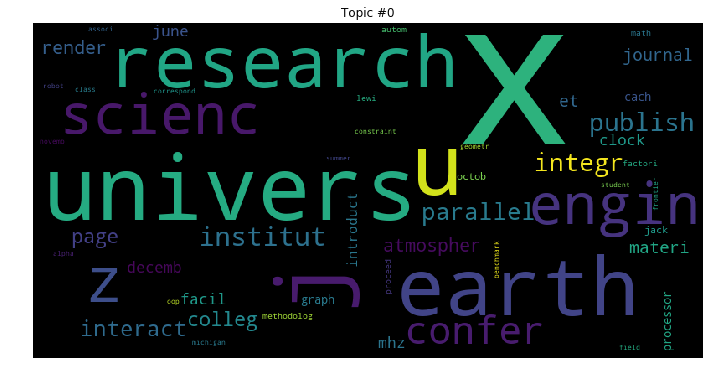

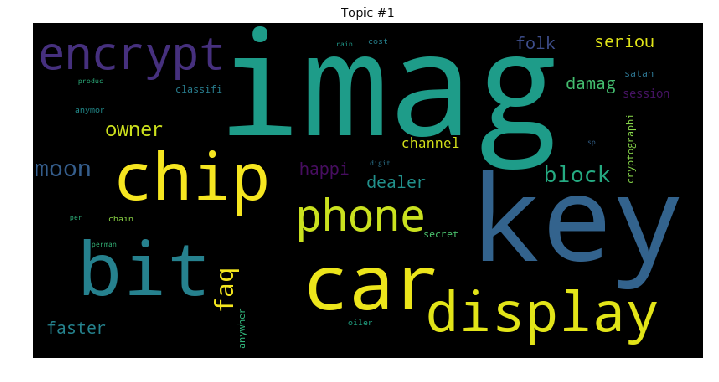

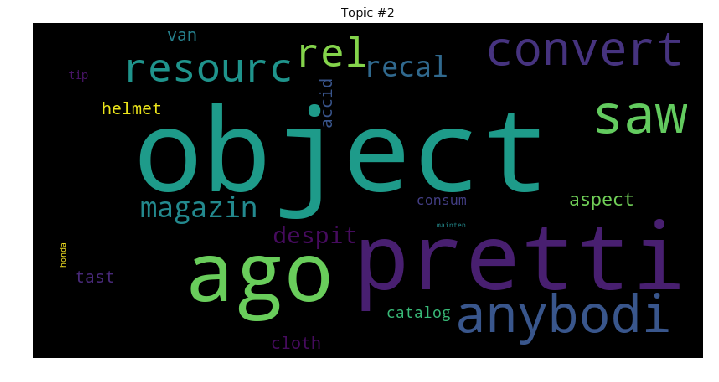

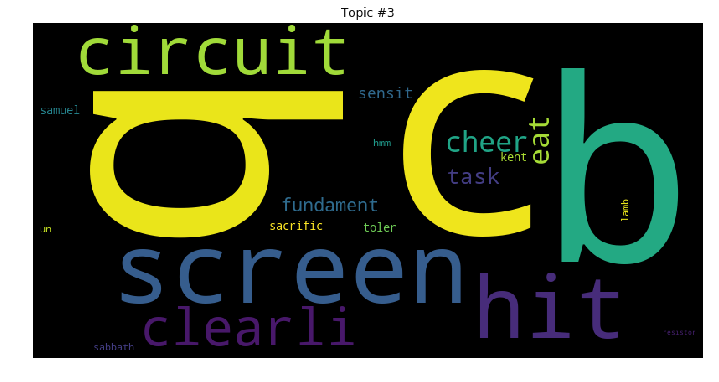

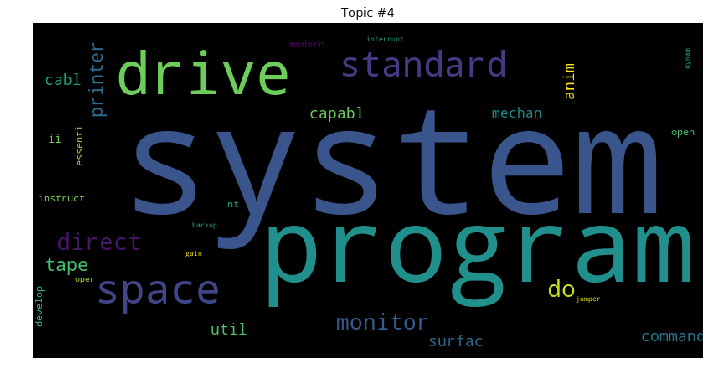

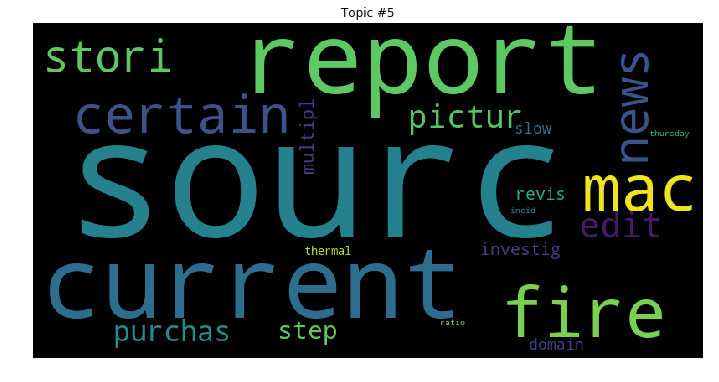

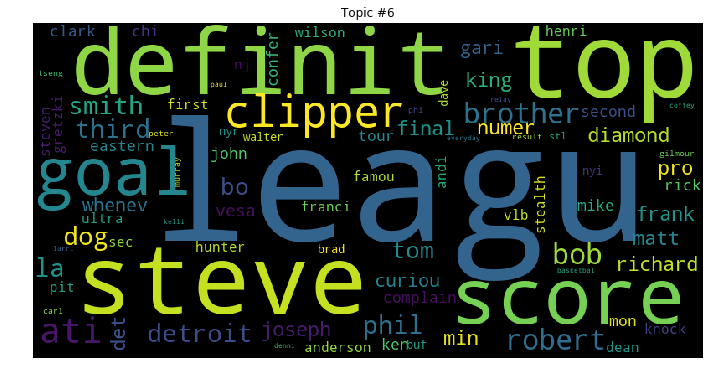

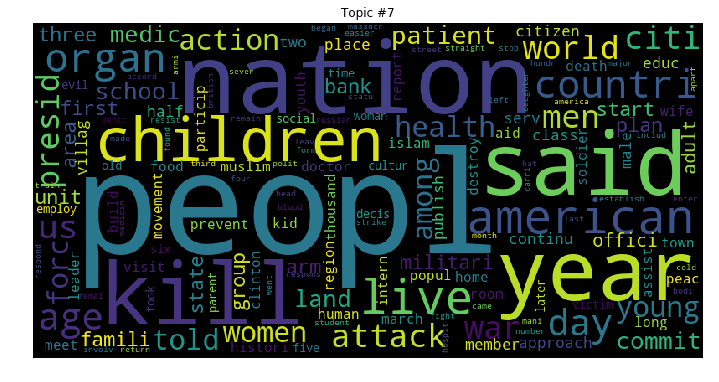

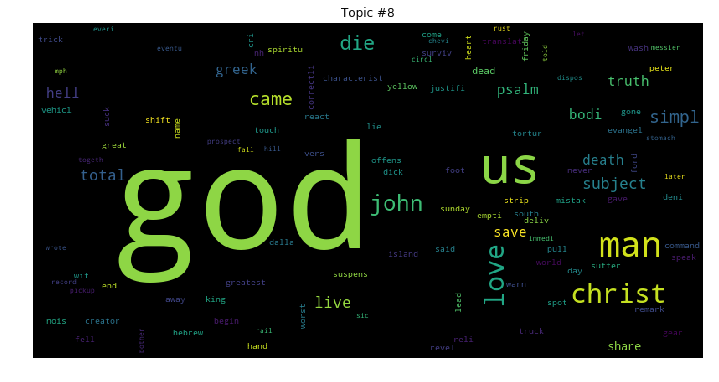

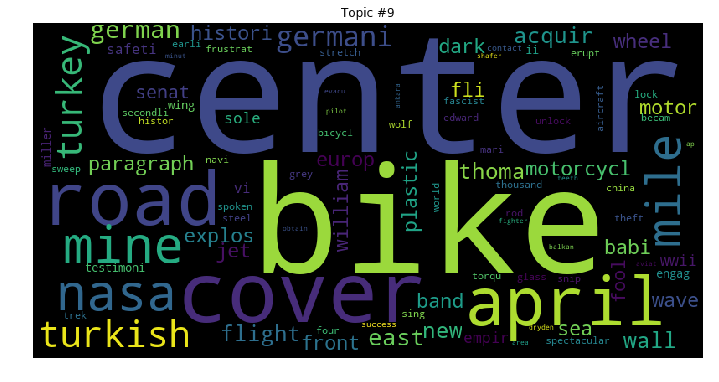

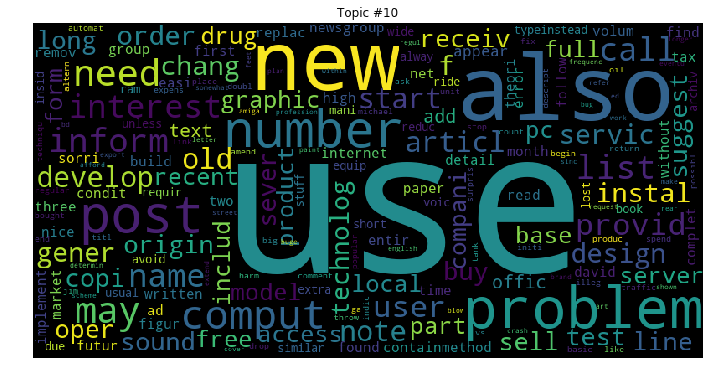

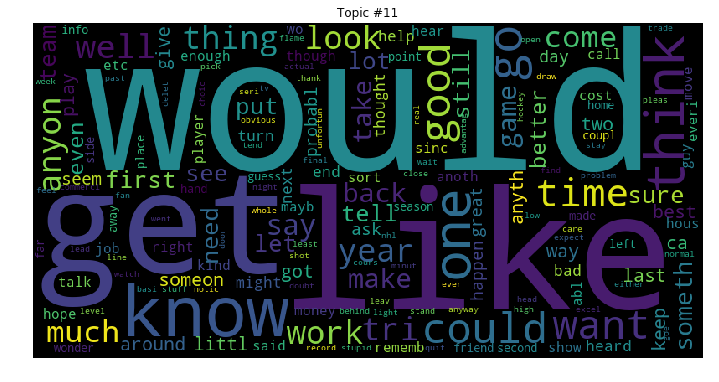

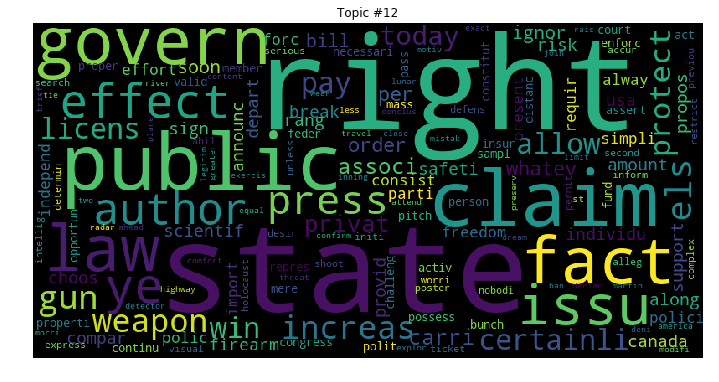

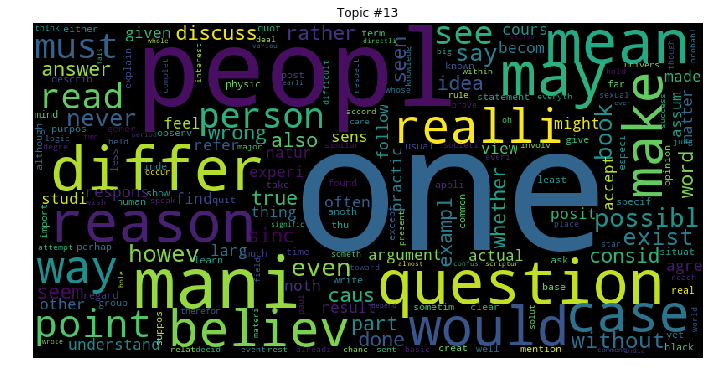

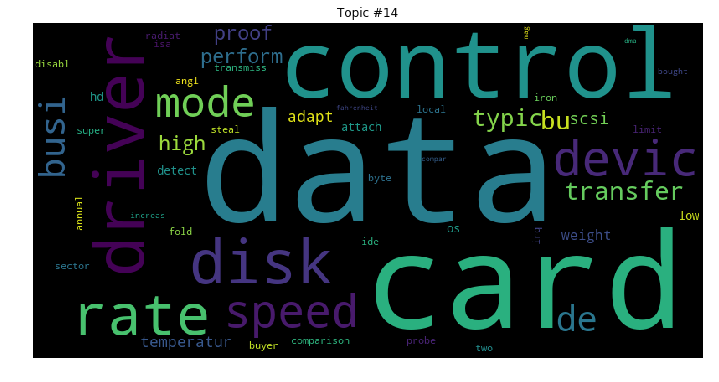

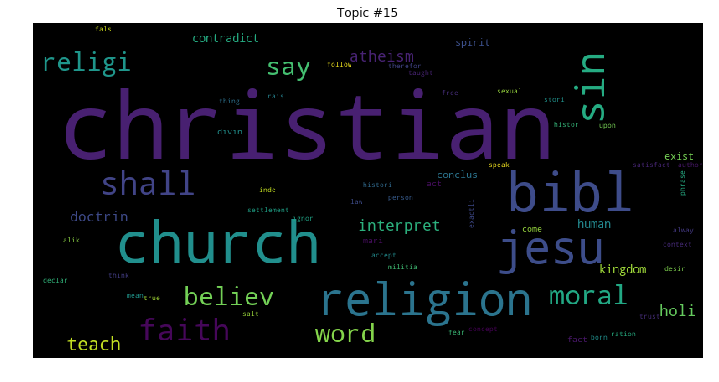

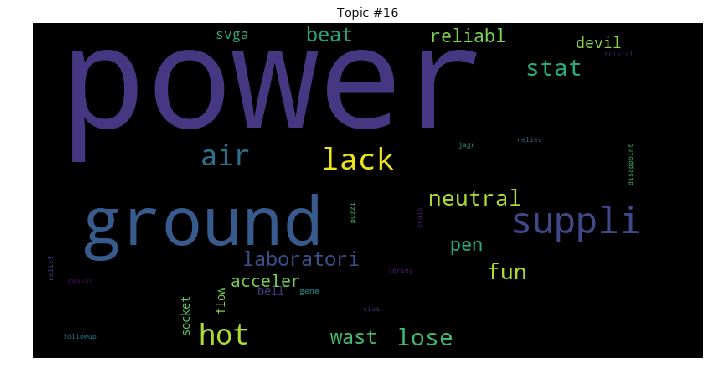

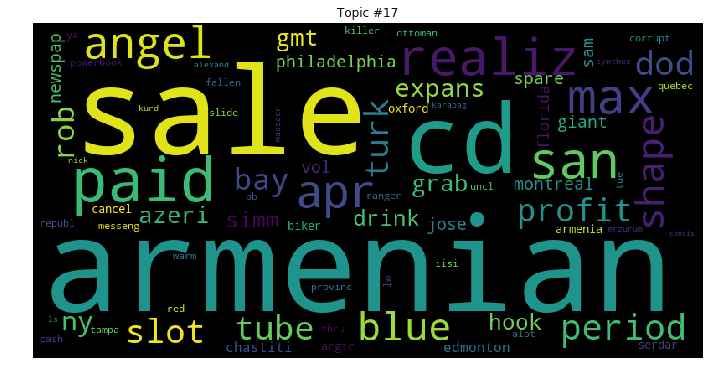

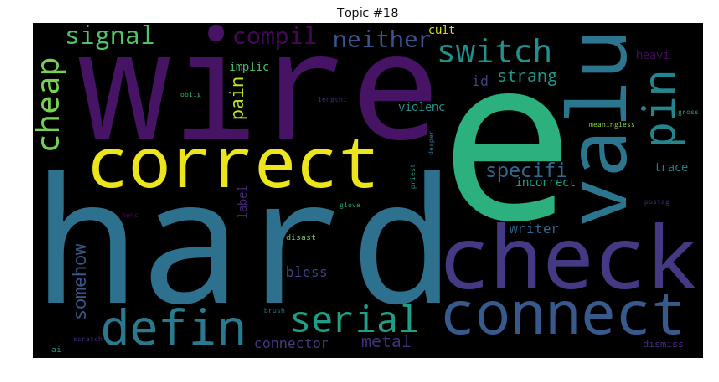

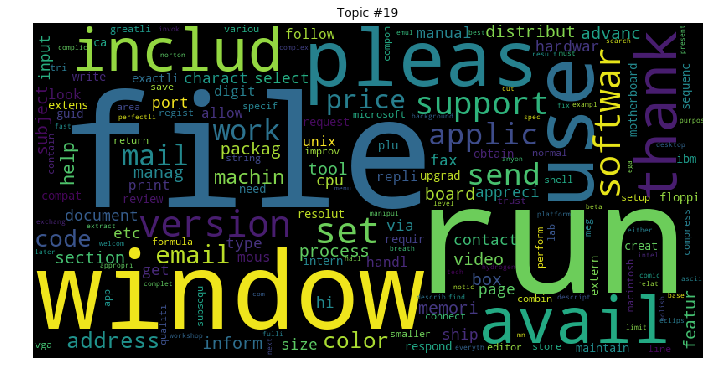

In [22]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

for idx in range(lda_model_bow_1.num_topics):
    plt.figure(figsize=(12,12))
    plt.imshow(WordCloud(relative_scaling=1,scale=2).fit_words(dict(lda_model_bow_1.show_topic(idx, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(idx))
    plt.show()

In [23]:
from collections import Counter
import matplotlib.colors as mcolors
topics = lda_model_bow_1.show_topics(20,200,formatted=False)
data_flat = [w for w_list in data_method_1 for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

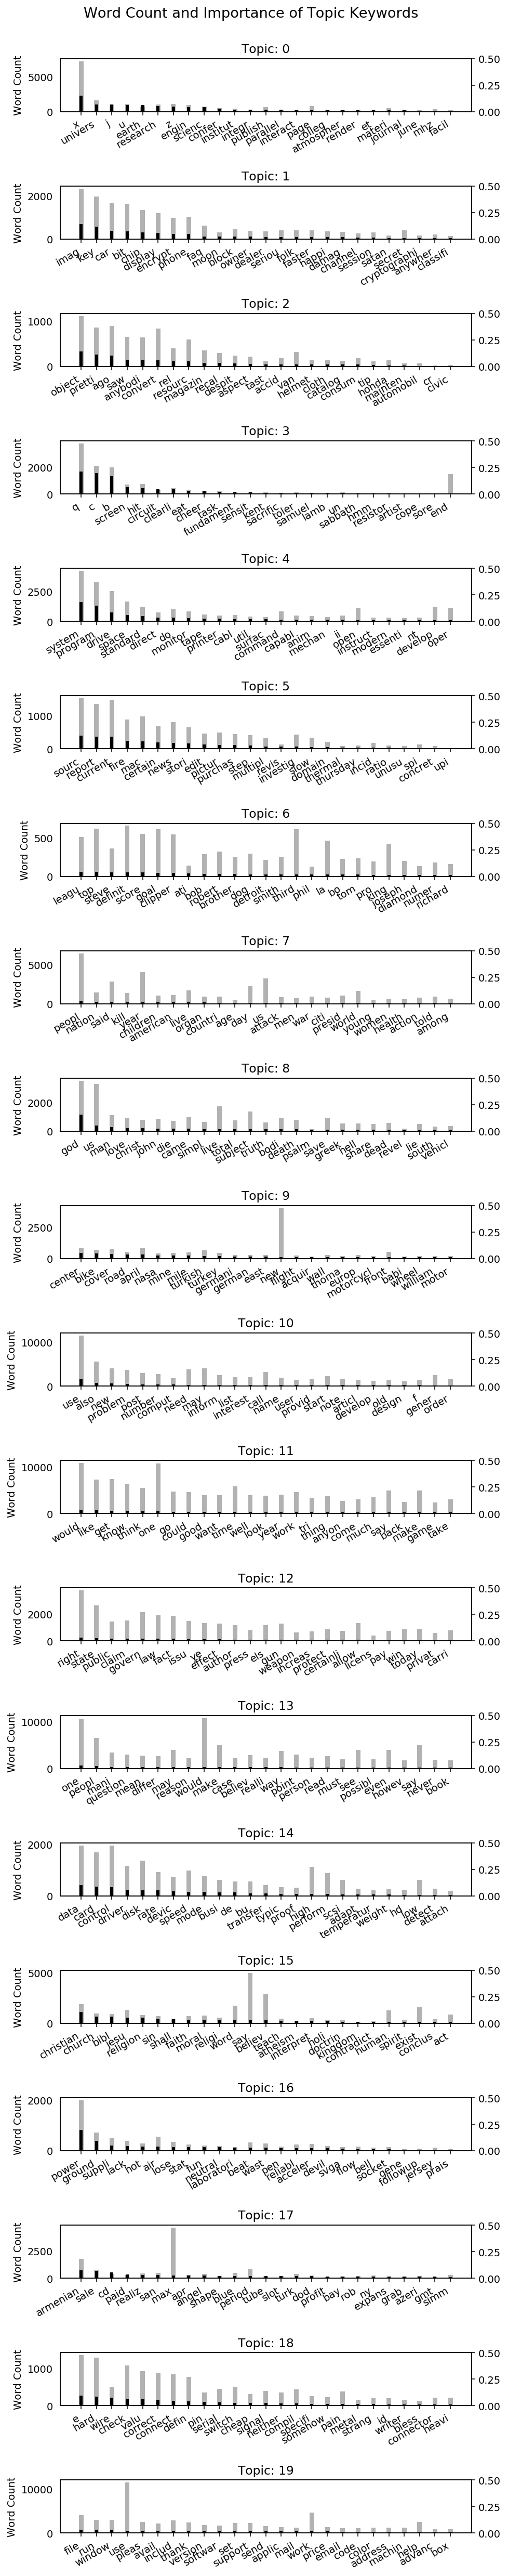

In [24]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(20, 1, figsize=(7,35), sharey=False, dpi=140)
#cols = [color for name, color in mcolors.CSS4_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :][:25], color="black", width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :][:25], color="black", width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color="black")
    ax_twin.set_ylim(0, .5); 
    ax.set_title('Topic: ' + str(i), color="black", fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

fig.tight_layout(w_pad=1)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=14, y=1.01)    
plt.show()

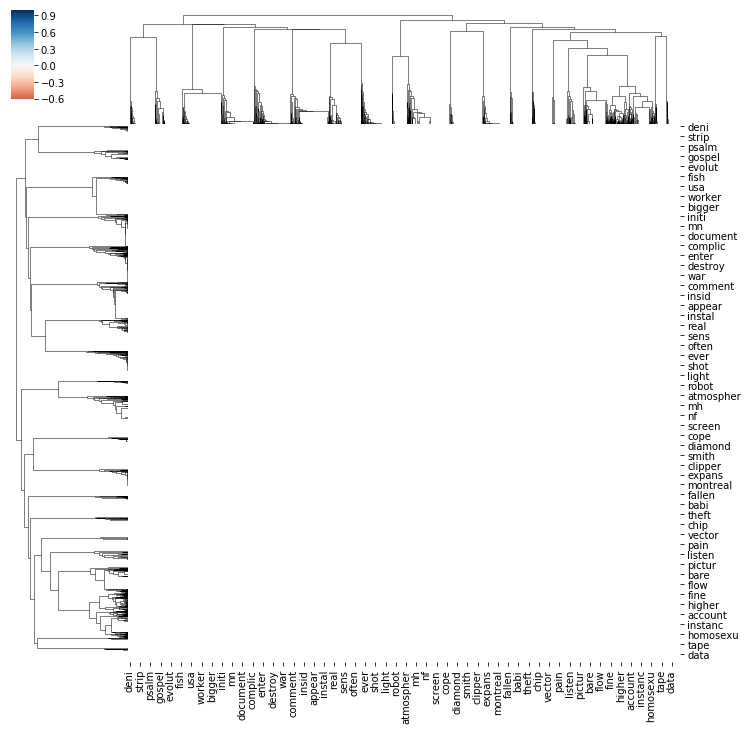

In [25]:
corpus_lda = lda_model_bow_1[corpus_tfidf]
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model_bow_1.show_topic(i,200)) for i in range(lda_model_bow_1.num_topics)}
import pandas as pd

df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()


In [26]:
lda_model_bow_1.print_topics()

[(0,
  '0.152*"x" + 0.066*"univers" + 0.065*"j" + 0.063*"u" + 0.060*"earth" + 0.053*"research" + 0.047*"z" + 0.042*"engin" + 0.041*"scienc" + 0.028*"confer"'),
 (1,
  '0.139*"imag" + 0.115*"key" + 0.075*"car" + 0.072*"bit" + 0.063*"chip" + 0.059*"display" + 0.048*"encrypt" + 0.046*"phone" + 0.026*"faq" + 0.024*"moon"'),
 (2,
  '0.141*"object" + 0.113*"pretti" + 0.101*"ago" + 0.065*"saw" + 0.064*"anybodi" + 0.059*"convert" + 0.051*"rel" + 0.051*"resourc" + 0.036*"magazin" + 0.035*"recal"'),
 (3,
  '0.212*"q" + 0.198*"c" + 0.167*"b" + 0.065*"screen" + 0.056*"hit" + 0.046*"circuit" + 0.045*"clearli" + 0.025*"eat" + 0.024*"cheer" + 0.019*"task"'),
 (4,
  '0.183*"system" + 0.148*"program" + 0.084*"drive" + 0.060*"space" + 0.051*"standard" + 0.034*"direct" + 0.033*"do" + 0.030*"monitor" + 0.025*"tape" + 0.024*"printer"'),
 (5,
  '0.124*"sourc" + 0.114*"report" + 0.113*"current" + 0.078*"fire" + 0.072*"mac" + 0.059*"certain" + 0.056*"news" + 0.050*"stori" + 0.041*"edit" + 0.038*"pictur"'),
 (

## Part 4
##### Document Targets (Topic Labels) and doc2vec Parameters

In [27]:
target_list = []
for idx, val in enumerate(newsgroups.target_names):
    target_list.append((idx, val))
target_list = dict(target_list) # create dict for mapping

# map topic label numbers to their respective topic names    
target_names = list(map(target_list.get, newsgroups_target))

# doc2vec parameters (used for both vocabularies)
min_count = 5
context_window = 20
vector_size = 100
downsample = 1e-5
negative_sampling = 5
num_threads = 4
num_epochs = 10



### Vocabulary 1

In [28]:
word_list1 = generate(newsgroups_data, 2)

# tag documents, build model and vocab, train model
docs1 = [TaggedDocument(doc, [i]) for i, doc in enumerate(word_list1)]
model1 = Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=40)
model1.build_vocab(docs1)
model1.train(docs1, total_examples=model1.corpus_count, epochs=model1.epochs)

model1.save('doc2vec_model1')
doc2vec_model1 = gensim.models.doc2vec.Doc2Vec.load('doc2vec_model1')

#doc2vec_model.docvecs.most_similar('christian') 

# put all doc vectors into dataframe (doc by doc vector)
docvecs1 = pd.DataFrame(doc2vec_model1.docvecs.vectors_docs)


In [29]:
# PCA
pca = PCA(n_components=2)
twoDocVecs1 = pca.fit_transform(docvecs1)

# PCA dataframe with with target (topic) names
DocVecsColors1 = pd.DataFrame(twoDocVecs1, columns=['PC1','PC2'])
DocVecsColors1['Categories'] = target_names


<Figure size 864x864 with 0 Axes>

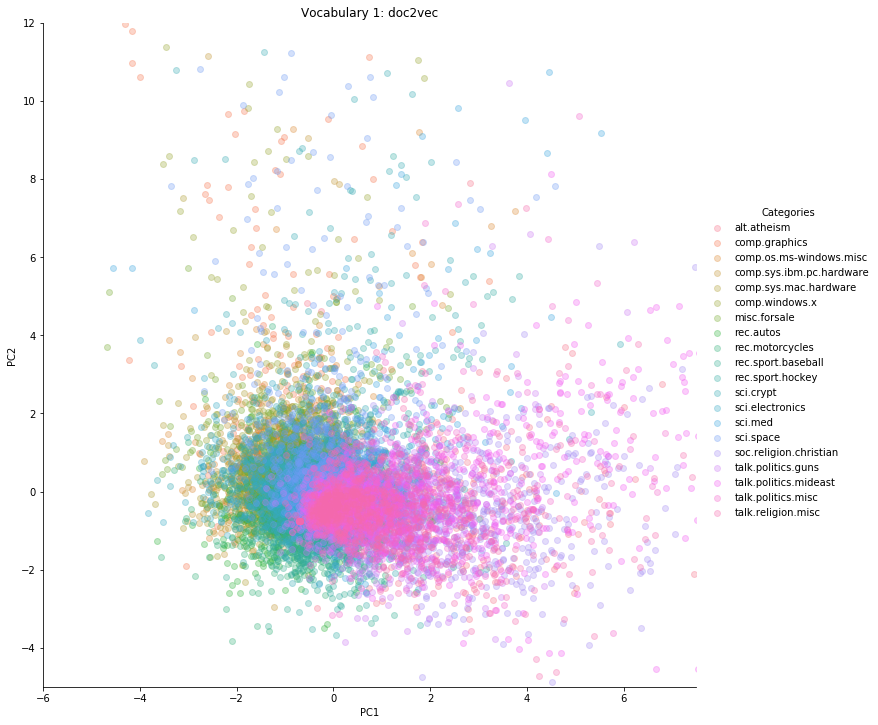

In [30]:
plt.figure(figsize=(12,12))
facet = sns.lmplot(data=DocVecsColors1, x='PC1', y='PC2', 
                   hue='Categories', 
                   fit_reg=False, 
                   legend=True, 
                   legend_out=True,
                   height=10,
                   scatter_kws={'alpha':0.3},
                   palette=None,
                   hue_order=newsgroups.target_names)
ax = plt.gca()
ax.set_xlim([-6, 7.5])
ax.set_ylim([-5, 12])
ax.set_title("Vocabulary 1: doc2vec")


plt.show()


### Vocabulary 2

In [31]:
word_list2 = generate(newsgroups_data, 1)

# tag documents, build model and vocab, train model
docs2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(word_list2)]
model2 = Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=40)
model2.build_vocab(docs2)
model2.train(docs2, total_examples=model2.corpus_count, epochs=model2.epochs)

model2.save('doc2vec_model2')
doc2vec_model2 = gensim.models.doc2vec.Doc2Vec.load('doc2vec_model2')

# put all doc vectors into dataframe (docs by doc vectors)
docvecs2 = pd.DataFrame(doc2vec_model2.docvecs.vectors_docs)


In [32]:
# PCA
pca = PCA(n_components=2)
twoDocVecs2 = pca.fit_transform(docvecs2)

# PCA dataframe with with target (topic) names
DocVecsColors2 = pd.DataFrame(twoDocVecs2, columns=['PC1','PC2'])
DocVecsColors2['Categories'] = target_names

<Figure size 864x864 with 0 Axes>

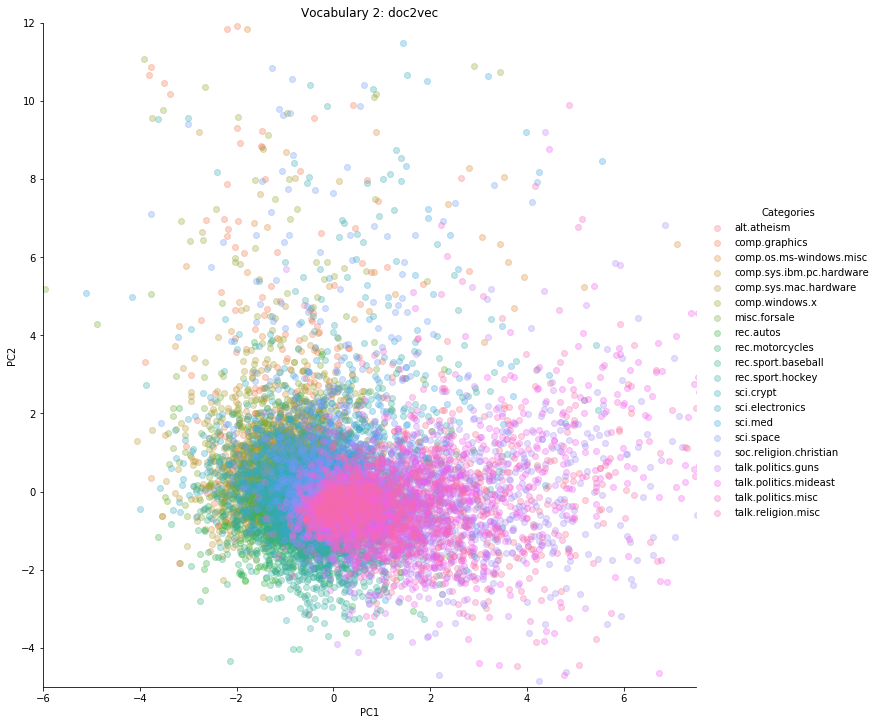

In [33]:
plt.figure(figsize=(12,12))
facet = sns.lmplot(data=DocVecsColors2, x='PC1', y='PC2', 
                   hue='Categories', 
                   fit_reg=False, 
                   legend=True, 
                   legend_out=True,
                   height=10,
                   scatter_kws={'alpha':0.3},
                   palette=None,
                   hue_order=newsgroups.target_names)
ax = plt.gca()
ax.set_xlim([-6, 7.5])
ax.set_ylim([-5, 12])
ax.set_title("Vocabulary 2: doc2vec")

plt.show()


In [2]:
# NMI score
from sklearn.metrics import normalized_mutual_info_score
a = kmeans.predict(twoDocVecs1) # use transpose if dimensions don't work
normalized_mutual_info_score(newsgroups_target,a) #y=newsgroups.target

##### Word Embedding

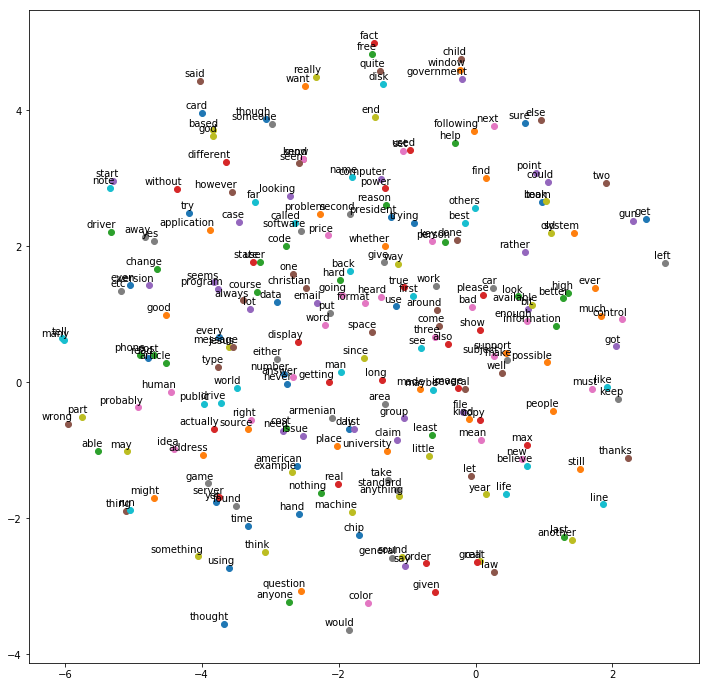

In [35]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    plt.figure(figsize=(12, 12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

doc2vec_tsne = Doc2Vec(vector_size=vector_size, window=context_window, min_count=1000, workers=num_threads, epochs=10)
doc2vec_tsne.build_vocab(docs1)
#doc2vec_tsne.train(docs1, total_examples=doc2vec_tsne.corpus_count, epochs=doc2vec_tsne.epochs)

tsne_plot(doc2vec_tsne)

#model1 = Doc2Vec(vector_size=vector_size, window=context_window, min_count=min_count, workers=num_threads)
#model1.build_vocab(docs1)
#model1

#tsne_plot(model1)

##### Document Embedding

In [36]:
import lda

n_topics = 20 # number of topics
n_iter = 500 # number of iterations

newsgroups_filtered_lda = [' '.join(words) for words in word_list1]

# vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(newsgroups_filtered_lda)

# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)





INFO:lda:n_documents: 18846
INFO:lda:vocab_size: 17354
INFO:lda:n_words: 1331331
INFO:lda:n_topics: 20
INFO:lda:n_iter: 500
/Users/alexsadler/anaconda3/lib/python3.7/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -16529009
INFO:lda:<10> log likelihood: -12317990
INFO:lda:<20> log likelihood: -11710222
INFO:lda:<30> log likelihood: -11509902
INFO:lda:<40> log likelihood: -11405434
INFO:lda:<50> log likelihood: -11342394
INFO:lda:<60> log likelihood: -11296188
INFO:lda:<70> log likelihood: -11269502
INFO:lda:<80> log likelihood: -11246533
INFO:lda:<90> log likelihood: -11231191
INFO:lda:<100> log likelihood: -11218024
INFO:lda:<110> log likelihood: -11207140
INFO:lda:<120> log likelihood: -11201792
INFO:lda:<130> log likelihood: -11193511
INFO:l

In [37]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(X_topics)

#corpus_tfidf

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18846 samples in 0.026s...
[t-SNE] Computed neighbors for 18846 samples in 15.540s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18846
[t-SNE] Computed conditional probabilities for sample 2000 / 18846
[t-SNE] Computed conditional probabilities for sample 3000 / 18846
[t-SNE] Computed conditional probabilities for sample 4000 / 18846
[t-SNE] Computed conditional probabilities for sample 5000 / 18846
[t-SNE] Computed conditional probabilities for sample 6000 / 18846
[t-SNE] Computed conditional probabilities for sample 7000 / 18846
[t-SNE] Computed conditional probabilities for sample 8000 / 18846
[t-SNE] Computed conditional probabilities for sample 9000 / 18846
[t-SNE] Computed conditional probabilities for sample 10000 / 18846
[t-SNE] Computed conditional probabilities for sample 11000 / 18846
[t-SNE] Computed conditional probabilities for sample 12000 / 18846
[t-SNE] Computed conditional probabilities for sa

In [ ]:
tsne_lda.

In [38]:
#lda_model = LDA(n_topics=20,max_iter=20)
#lda_model.fit(tfidf_matrix)

#lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
#X_topics = lda_model.fit_transform(cvz)

In [39]:
#tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
#tsne_lda = tsne_model.fit_transform(np.transpose(lda_model.components_))

#corpus_tfidf

In [40]:
# get topic summaries
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(' '.join(topic_words)) # append!

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

<Figure size 864x864 with 0 Axes>

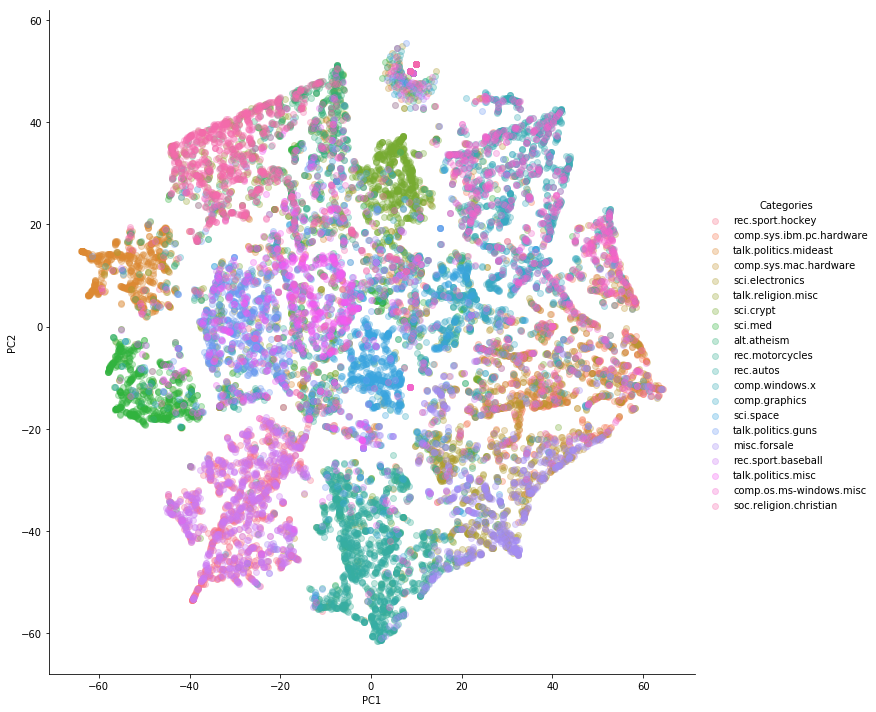

In [67]:
tsne_lda_df = pd.DataFrame(tsne_lda, columns=['PC1', 'PC2'])
tsne_lda_df['Categories'] = target_names
plt.figure(figsize=(12,12))
facet = sns.lmplot(data=tsne_lda_df, x='PC1', y='PC2', 
                   hue='Categories', 
                   fit_reg=False, 
                   legend=True, 
                   legend_out=True,
                   height=10,
                   scatter_kws={'alpha':0.3},
                   palette=None)
                   #hue_order=newsgroups.target_names)

newsgroups.target_names
[10, ]


In [55]:
topic_summaries
for idx in range(len(topic_summaries)):
    print("Topic " + str(idx) + ": " + topic_summaries[idx][:50])



Topic 0: right state government people law country american
Topic 1: file image program jpeg format entry use color out
Topic 2: key chip encryption use clipper government phone s
Topic 3: car bike engine like new mile speed ride road prob
Topic 4: game team player year play season win hockey perio
Topic 5: god jesus christian church bible christ sin word l
Topic 6: list information send mail address book email grou
Topic 7: max space launch mission earth satellite nasa orbi
Topic 8: window use program application file server using p
Topic 9: power used sale price use offer like sell new wire
Topic 10: president said stephanopoulos think know myers new
Topic 11: gun weapon crime fbi law police firearm koresh dea
Topic 12: like think know people time thing good want make r
Topic 13: said people went time say woman know day told came
Topic 14: year program new state national number research se
Topic 15: drive card disk problem driver mac know work use h
Topic 16: image data graphic avail

In [65]:
# get topic summaries
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(str(i) + ' '.join(topic_words)) # append!



[]

# K-means Clustering

#### TF-IDF

In [43]:
# reduce dimensions using truncated SVD
svd = TruncatedSVD(n_components=2, n_iter=5)
two_vecs_tfidf = svd.fit_transform(tfidf_matrix.T)


<Figure size 864x864 with 0 Axes>

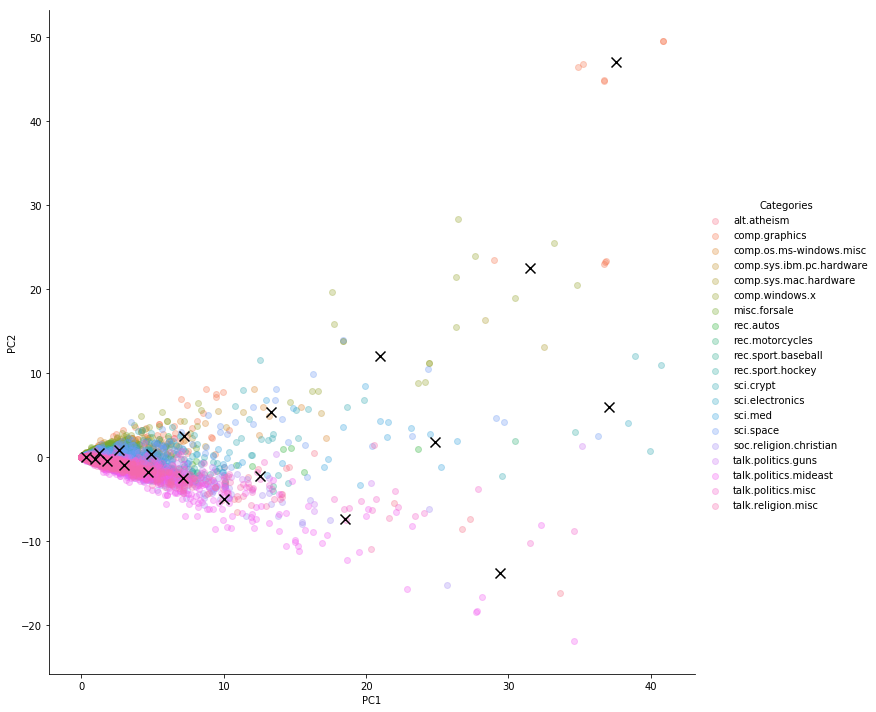

In [44]:
two_vecs_tfidf_df = pd.DataFrame(two_vecs_tfidf, columns=(['PC1','PC2']))
two_vecs_tfidf_df['Categories'] = target_names

plt.figure(figsize=(12,12))
facet = sns.lmplot(data=two_vecs_tfidf_df, x='PC1', y='PC2', 
                   hue='Categories', 
                   fit_reg=False, 
                   legend=True, 
                   legend_out=True,
                   height=10,
                   scatter_kws={'alpha':0.3},
                   palette=None,
                   hue_order=newsgroups.target_names)

kmeans_tfidf = KMeans(n_clusters=20, random_state=0).fit(two_vecs_tfidf)
for x, y in kmeans_tfidf.cluster_centers_:
    plt.scatter(x, y, marker='x', s=100, c='k')

#### BoW

In [45]:
# reduce dimensions using truncated SVD
svd = TruncatedSVD(n_components=2, n_iter=5)
two_vecs_bow = svd.fit_transform(bow_matrix.T)


<Figure size 864x864 with 0 Axes>

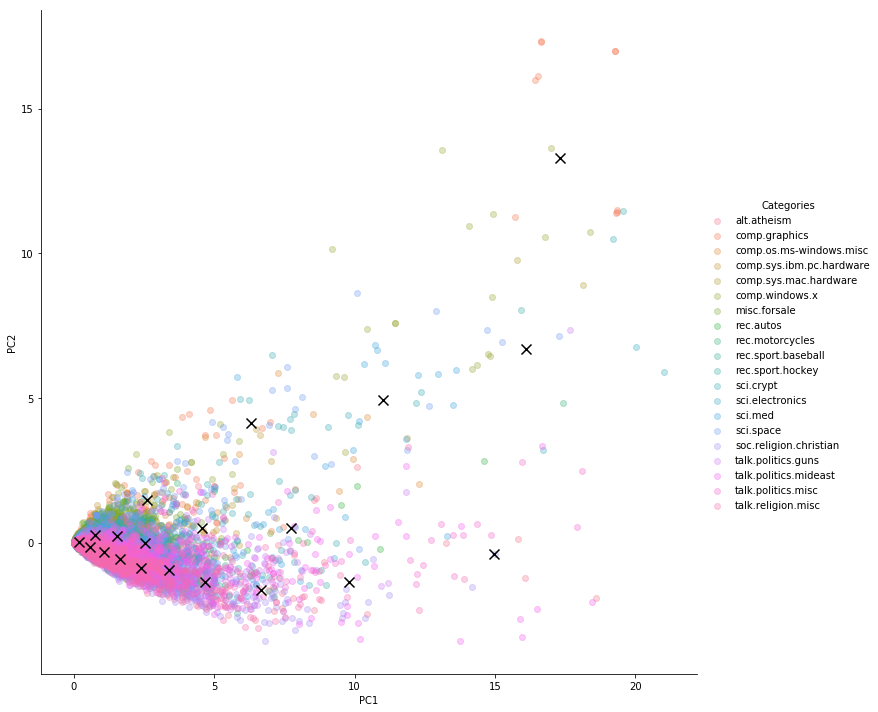

In [46]:
two_vecs_bow_df = pd.DataFrame(two_vecs_bow, columns=(['PC1','PC2']))
two_vecs_bow_df['Categories'] = target_names

plt.figure(figsize=(12,12))
facet = sns.lmplot(data=two_vecs_bow_df, x='PC1', y='PC2', 
                   hue='Categories', 
                   fit_reg=False, 
                   legend=True, 
                   legend_out=True,
                   height=10,
                   scatter_kws={'alpha':0.3},
                   palette=None,
                   hue_order=newsgroups.target_names)

kmeans_bow = KMeans(n_clusters=20, random_state=0).fit(two_vecs_bow)
for x, y in kmeans_bow.cluster_centers_:
    plt.scatter(x, y, marker='x', s=100, c='k')

#### Topics Distribution

In [47]:
lda = LDA(n_topics=20,max_iter=20)
lda.fit(tfidf_matrix)


/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=20, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

<Figure size 864x864 with 0 Axes>

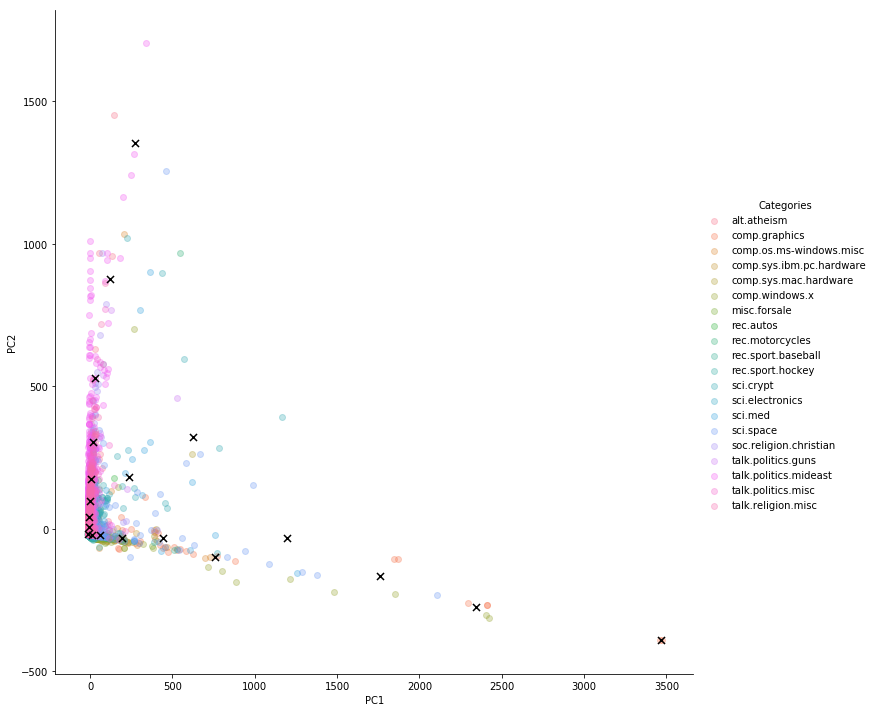

In [48]:
pca = PCA(n_components=2)
two_vecs_LDA = pca.fit_transform(np.transpose(lda.components_))
two_vecs_LDA_df = pd.DataFrame(two_vecs_LDA,columns=(['PC1', 'PC2']))
two_vecs_LDA_df['Categories'] = target_names


plt.figure(figsize=(12,12))
facet = sns.lmplot(data=two_vecs_LDA_df, x='PC1', y='PC2', 
                   hue='Categories', 
                   fit_reg=False, 
                   legend=True, 
                   legend_out=True,
                   height=10,
                   scatter_kws={'alpha':0.3},
                   palette=None,
                   hue_order=newsgroups.target_names)
ax = plt.gca()
#ax.set_xlim([-25,200])
#ax.set_ylim([-100,300])

kmeans_lda = KMeans(n_clusters=20, random_state=0).fit(two_vecs_LDA)
for x, y in kmeans_lda.cluster_centers_:
    plt.scatter(x, y, marker='x', s=50, c='k')

#X = np.transpose(lda_large.components_)
#twoDimLDAdocVecs = pca.fit_transform(X)

#### doc2vec

<Figure size 864x864 with 0 Axes>

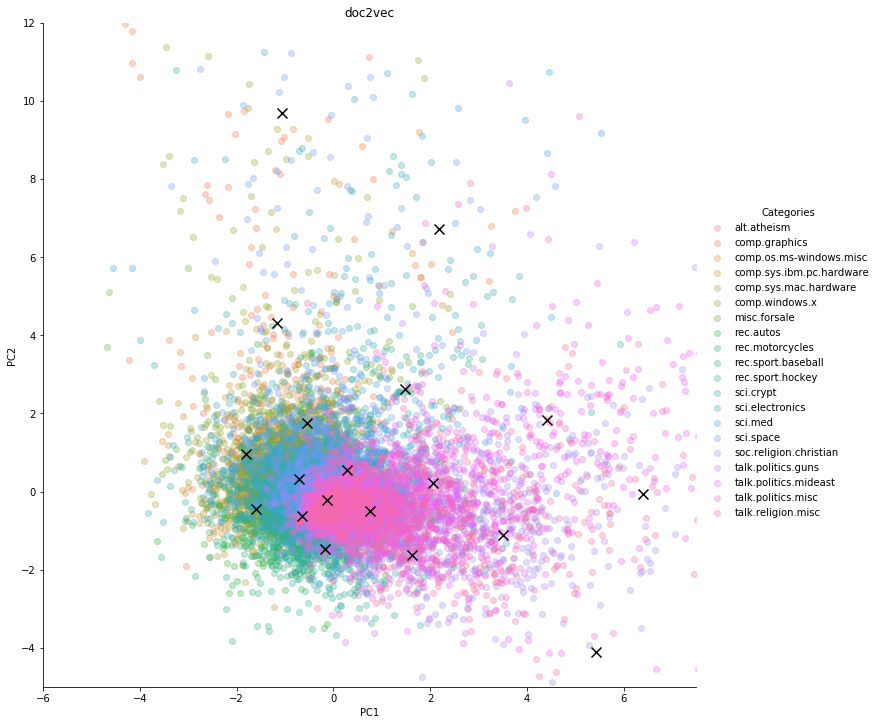

In [50]:
plt.figure(figsize=(12,12))
facet = sns.lmplot(data=DocVecsColors1, x='PC1', y='PC2', 
                   hue='Categories', 
                   fit_reg=False, 
                   legend=True, 
                   legend_out=True,
                   height=10,
                   scatter_kws={'alpha':0.3},
                   palette=None,
                   hue_order=newsgroups.target_names)
ax = plt.gca()
ax.set_xlim([-6, 7.5])
ax.set_ylim([-5, 12])
ax.set_title("doc2vec")

kmeans = KMeans(n_clusters=20).fit(twoDocVecs1)
for x, y in kmeans.cluster_centers_:
    plt.scatter(x, y, marker='x', s=100, c='k')

plt.show()
